In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv('/content/drive/My Drive/Sharer.pw/dataset_final.csv')
df.set_index(pd.to_datetime(df.date),inplace=True)
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)
df.head()
test_data = pd.concat([df['2020-02'],df['2020-03'],df['2020-04']],axis=0)
train_data = df[:-len(test_data)]

train_data

,btc_price,gold_price,oil_wti_price,sp500_close,btc_num_trans,btc_google_search,btc_dr,gold_dr,oil_dr,sp500_dr,BVOL,GVOL,OVOL,VIX
date,,,,,,,,,,,,,,
2015-01-15,211.91,1352.8,46.37,1992.67,102309.0,3,0.568670,0.021141,-0.044705,-0.009291,0.853974,0.344132,0.344950,22.39
2015-01-16,199.46,1364.9,48.49,2019.42,104699.0,3,-0.060548,0.008905,0.044705,0.013335,0.857286,0.348453,0.346061,20.95
2015-01-20,208.00,1377.4,46.79,2022.55,98485.0,3,0.041924,0.009116,-0.035688,0.001549,0.857176,0.348518,0.346647,19.89
2015-01-21,225.51,1378.4,47.85,2032.12,98485.0,3,0.080826,0.000726,0.022402,0.004720,0.893605,0.350149,0.347336,18.85
2015-01-22,226.32,1390.2,45.93,2063.15,93698.0,3,0.003585,0.008524,-0.040953,0.015154,0.904949,0.351242,0.343230,16.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,8895.96,1589.5,53.09,3243.63,261247.0,13,0.054126,0.003529,-0.018661,-0.015856,0.400895,0.103554,0.281172,18.23
2020-01-28,9394.50,1581.7,53.33,3276.24,261247.0,13,0.054527,-0.004919,0.004510,0.010003,0.393217,0.104977,0.288948,16.28
2020-01-29,9288.44,1582.0,53.29,3273.40,340562.0,13,-0.011354,0.000190,-0.000750,-0.000867,0.397007,0.104557,0.292484,16.39


In [3]:
train_data = train_data[['btc_dr','gold_dr','oil_dr','sp500_dr']]
X = train_data.values
scalar = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scalar.fit_transform(X)

In [4]:
X_train = []
y_train = []

n_future = len(test_data)   # Number of days we want top predict into the future
timesteps = 5    # Number of past days we want to use to predict the future
for i in range(timesteps, len(X) - n_future +1):
    X_train.append(X[i - timesteps:i, 0:X.shape[1] - 1])
    y_train.append(X[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f'X_train shape = {X_train.shape}.')
print(f'y_train shape = {y_train.shape}.')

X_train shape = (1201, 5, 3).
y_train shape = (1201, 1).


In [5]:
units = 128
learning_rate = 0.0001

def lstm_model():
  model = Sequential()
  model.add(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))) 
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mae')
  return model

model = lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(X_train,y_train,epochs=50,shuffle=False)

Epoch 1/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0871
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 4/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 5/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 6/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0398
Epoch 7/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0396
Epoch 8/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0389
Epoch 9/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0392
Epoch 10/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0387
Epoch 11/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0388
Epoch 12/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0384
Epoch 13/50
38/38 [==============================

In [7]:
 p = model.predict(X_train[-n_future:])
sc = preprocessing.MinMaxScaler(feature_range=(0,1))
sc.fit(train_data.btc_dr.values.reshape((-1,1)))
p = sc.inverse_transform(p)

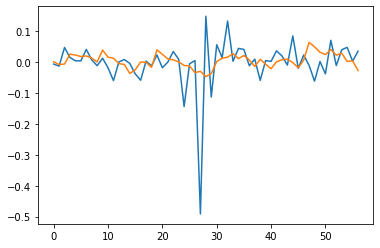

In [8]:
plt.figure()
plt.plot(test_data.btc_dr.values)
plt.plot(p*10)